Import all essential libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.utils import resample

add values to dataframes

In [2]:
df1 = pd.read_csv('train.csv')
df2 = pd.read_csv('test.csv')
df3 = pd.read_csv('expected.csv')

In [3]:
unique_classes = np.unique(df1.y)
class_counts = df1.y.value_counts()
class_counts
# max_class_count = np.max(class_counts)
print(unique_classes)

[3 4 5 6 7 8 9]


In [4]:
upsampled = pd.DataFrame()

for unique_class in unique_classes:
    class_df = df1[df1.y == unique_class]
    if len(class_df) < 80:
        class_df_upsampled = resample(class_df,
                                      replace=True,
                                      n_samples=80,
                                      random_state=42)
        upsampled = pd.concat([upsampled, class_df_upsampled])
    else:
        upsampled = pd.concat([upsampled, class_df])

# Separate features and target vector
df1 = upsampled

In [5]:
df1.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,y
count,3401.000000,3404.000000,3396.000000,3408.000000,3391.000000,3401.000000,3405.000000,3384.000000,3406.000000,3404.000000,3408.000000,3407.000000,3408.000000,3408.000000,3334.000000,3408.000000
mean,6.880888,0.277403,0.337624,68.713542,6.369316,0.045286,0.997996,35.279551,0.502990,0.832071,137.546802,0.993986,3.189792,0.488791,10.553149,5.898181
std,0.909317,0.100442,0.122041,21.513906,5.086679,0.021575,0.077924,17.150083,0.023322,0.301594,42.882100,0.003060,0.152362,0.113802,1.263802,1.063533
min,3.800000,0.080000,0.000000,4.500000,0.600000,0.009000,0.000300,2.000000,0.000300,0.010000,9.000000,0.987220,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,53.500000,1.700000,0.035000,0.995791,23.000000,0.489958,0.630000,107.000000,0.991600,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,66.500000,5.100000,0.042000,0.996845,34.000000,0.502427,0.780000,133.000000,0.993700,3.180000,0.470000,10.400000,6.000000
75%,7.400000,0.320000,0.390000,83.000000,9.900000,0.050000,0.998098,46.000000,0.515874,0.960000,166.000000,0.996200,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,172.000000,65.800000,0.346000,5.432281,138.500000,0.580925,3.300000,344.000000,1.038980,3.810000,1.080000,14.050000,9.000000


In [6]:
# df1 = df1.drop_duplicates()

In [7]:
# sort dataframe using y values
df1 = df1.sort_values('y', ascending=True).reset_index(drop=True)

In [8]:
# concatenate test data to pre process
df2_wr = df2.copy()

df2 = pd.concat([df2, df3], axis=1)

In [9]:
# fill missing values using forward fill method
df1 = df1.fillna(method = 'ffill')
df2 = df2.fillna(method = 'ffill')

In [10]:
# train x and train y
df1_x = df1.drop(['y'], axis =1)
df1_y = df1["y"]

In [11]:
# remove outliers
df_clean = df1_x[(df1_x > df1_x.quantile(0.0001)) & (df1_x < df1_x.quantile(0.9999))]

In [12]:
df1 = pd.concat([df_clean, df1_y], axis=1)
df1 = df1.dropna()

Select 13 best features using mutual information

In [13]:
mutual_info = mutual_info_classif(df1_x, df1_y)
selected_features = df1_x.columns[np.argsort(mutual_info)[::-1][:13]]
print(selected_features)

Index(['x7', 'x12', 'x15', 'x4', 'x11', 'x5', 'x6', 'x8', 'x13', 'x10', 'x2',
       'x9', 'x1'],
      dtype='object')


In [14]:
df1_x = df1[selected_features]
df1_y = df1["y"]

In [15]:
df2_x = df2[selected_features]
df2_y = df2['y']

Feature scaling using standard scaler

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df1_x = scaler.fit_transform(df1_x) #the scaler is fitted to the training set and then transformed
df2_x = scaler.transform(df2_x)       #the scaler is applied to the test set

df1_x = pd.DataFrame(df1_x, columns=selected_features)
df2_x = pd.DataFrame(df2_x, columns=selected_features)

df1 = pd.concat([df1_x, df1_y], axis=1)

In [17]:
df1.head()

,x7,x12,x15,x4,x11,x5,x6,x8,x13,x10,x2,x9,x1,y
0,-0.023989,-0.025242,-0.761775,-2.440037,-2.451388,-0.995220,-0.394864,-1.764930,-1.975267,-1.092481,-1.092481,-1.952889,3.870071,3.0
1,-0.007106,-0.008370,0.354768,1.646702,1.649594,0.426217,-0.394864,5.174480,-1.908906,-0.371703,-0.371703,-1.883087,2.847333,3.0
2,1.931601,1.931819,-0.682022,-0.338285,-0.342311,0.946743,-0.537609,-1.181787,-1.709822,-0.474672,-0.474672,-1.675119,5.574633,3.0
3,-0.007106,-0.008370,0.354768,1.646702,1.649594,0.426217,-0.394864,5.174480,-1.908906,-0.371703,-0.371703,-1.883087,2.847333,3.0
4,-0.902485,-0.902545,0.913040,-0.665224,-0.670390,-0.574795,-0.775516,-1.764930,2.271857,-0.371703,-0.371703,2.089432,-1.243616,3.0


Visualize outliers

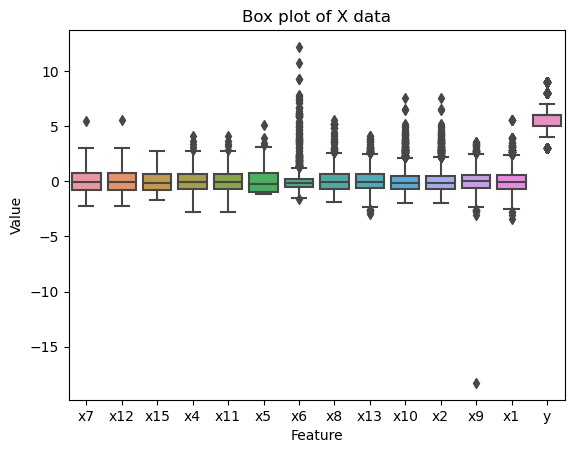

In [18]:
sns.boxplot(data=df1)

plt.title("Box plot of X data")
plt.xlabel("Feature")
plt.ylabel("Value")

plt.show()

In [19]:
df1_y.unique()

array([3, 4, 5, 6, 7, 8, 9], dtype=int64)

Correlated Features: ['x12', 'x11', 'x2', 'x9']


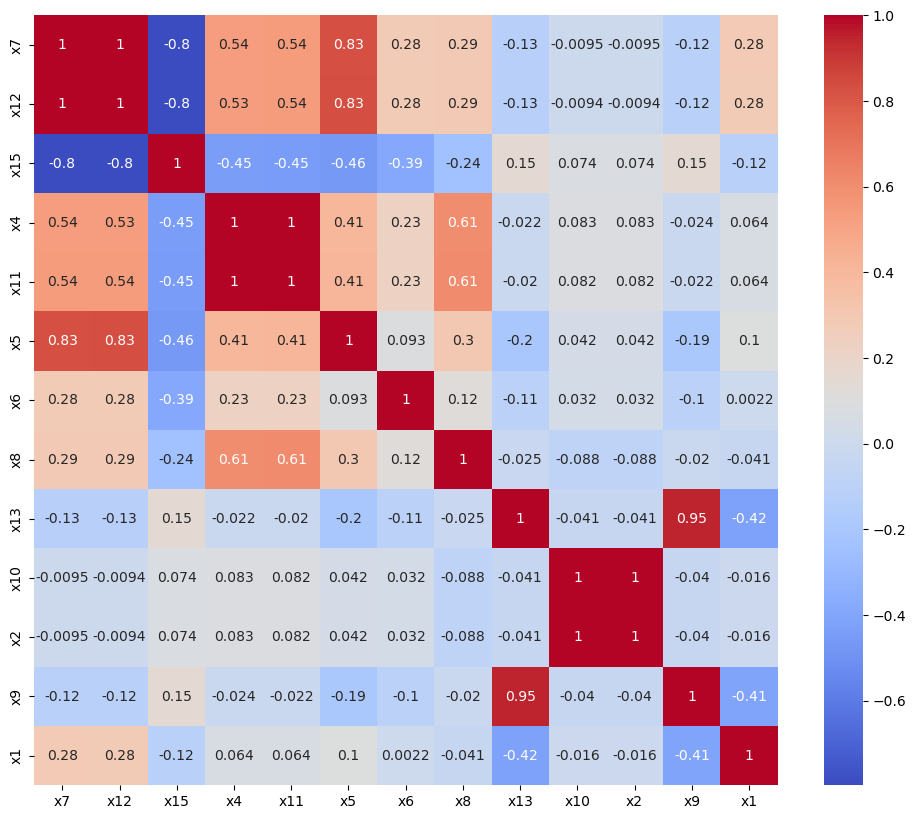

In [20]:
corr_matrix = df1_x.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

threshold = 0.9
corr_features = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i,j]) > threshold:
            corr_features.append(corr_matrix.columns[i])
            break

print('Correlated Features:', corr_features)


Drop the correlated features

In [21]:
df1_x = df1_x.drop(corr_features, axis =1)
df2_x = df2_x.drop(corr_features, axis=1)

In [22]:
df1.describe()

,x7,x12,x15,x4,x11,x5,x6,x8,x13,x10,x2,x9,x1,y
count,3.358000e+03,3.358000e+03,3.358000e+03,3.358000e+03,3.358000e+03,3.358000e+03,3.358000e+03,3.358000e+03,3.358000e+03,3.358000e+03,3.358000e+03,3.358000e+03,3.358000e+03,3358.000000
mean,-5.185198e-14,-2.984939e-14,2.542999e-15,-3.926447e-16,1.837588e-16,-6.469248e-16,2.818208e-16,-1.199491e-16,-1.584994e-15,-3.809407e-16,-1.006871e-15,3.763120e-15,-2.144370e-15,5.912150
std,1.000149e+00,1.000149e+00,1.000149e+00,1.000149e+00,1.000149e+00,1.000149e+00,1.000149e+00,1.000149e+00,1.000149e+00,1.000149e+00,1.000149e+00,1.000149e+00,1.000149e+00,1.053115
min,-2.215615e+00,-2.211751e+00,-1.718813e+00,-2.790329e+00,-2.802901e+00,-1.135361e+00,-1.584402e+00,-1.881559e+00,-2.970687e+00,-1.967710e+00,-1.967710e+00,-1.827992e+01,-3.402729e+00,3.000000
25%,-8.010609e-01,-8.013174e-01,-8.415285e-01,-7.119299e-01,-7.172585e-01,-9.351590e-01,-4.900272e-01,-7.152715e-01,-6.480406e-01,-6.806079e-01,-6.806079e-01,-6.498438e-01,-6.754290e-01,5.000000
50%,-9.152482e-02,-9.272636e-02,-1.237503e-01,-1.047572e-01,-1.079696e-01,-2.544710e-01,-1.569566e-01,-7.381336e-02,-5.078874e-02,-1.657671e-01,-1.657671e-01,-2.055984e-02,-1.072416e-01,6.000000
75%,7.521847e-01,7.508344e-01,6.737809e-01,6.892378e-01,6.887927e-01,7.065003e-01,2.236954e-01,6.259592e-01,6.128244e-01,4.520419e-01,4.520419e-01,6.051070e-01,5.745834e-01,6.000000
max,5.491008e+00,5.508517e+00,2.747362e+00,4.098746e+00,4.110184e+00,5.050891e+00,1.216665e+01,5.582681e+00,4.063613e+00,7.505361e+00,7.505361e+00,3.578784e+00,5.574633e+00,9.000000


In [23]:
# code for parameter tuning


# max_depths = [2*i for i in range(1,15)]
# min_samples_splits = [2]
# min_samples_leafs =  [1, 2, 4]
# best_score = 0

# for max_depth in max_depths:
#     for min_samples_split in min_samples_splits:
#         for min_samples_leaf in min_samples_leafs:
#             # Create a random forest classifier with the current hyperparameters
#             random_forest = RandomForestClassifier(n_estimators = 100, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

#             # Evaluate the random forest classifier with cross-validation
#             accuracy_list = cross_val_score(random_forest, df1_x, df1_y, cv=5)
#             accuracy = accuracy_list.mean()

#             # Check if the current hyperparameters give better accuracy than previous ones
#             if accuracy > best_score:
#                 best_score = accuracy
#                 best_params = {'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}
#                 print(f'Best hyperparameters: {best_params}')
#                 print(f'Accuracy: {best_score}')


# print(f'Best hyperparameters: {best_params}')
# print(f'Accuracy: {best_score}')

In [24]:
rf = RandomForestClassifier(n_estimators = 100, max_depth=2, min_samples_split=16, min_samples_leaf=1)
accuracy_list = cross_val_score(rf, df1_x, df1_y, cv=5)
accuracy = accuracy_list.mean()
print(accuracy)

rf.fit(df1_x, df1_y)
y_pred = rf.predict(df2_x)
accuracy = accuracy_score(df2_y,y_pred)
print(accuracy)

0.4982151728053368
0.42743417023882424


In [25]:
df1_y.unique()

array([3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [26]:
train = pd.concat([df1_x, df1_y], axis=1)
train = train.dropna()
train.to_csv(' 200647R_lab1_train.csv', index=False)

y_pred = pd.Series(y_pred)

test = pd.concat([df2_x, y_pred], axis=1)
test = test.dropna()
test.to_csv(' 200647R_lab1_test.csv', index=False)